In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, LSTM, Flatten
from keras.optimizers import SGD

from matplotlib import pyplot as plt
from IPython.display import clear_output

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import signal_m as s

In [4]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.loss = []
        self.val_loss = []
        self.logs = []
        
        self.fig = plt.figure()

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.loss, label="loss")
        plt.plot(self.x, self.val_loss, label="val_loss")
        plt.legend()
        plt.show();

In [5]:
import numpy as np
plot_losses = PlotLosses()

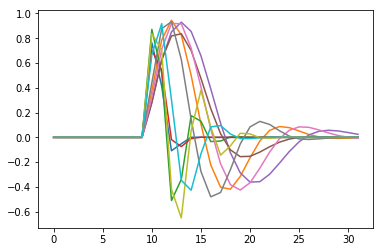

In [8]:
plt.plot(x[0:10].T)
plt.show()

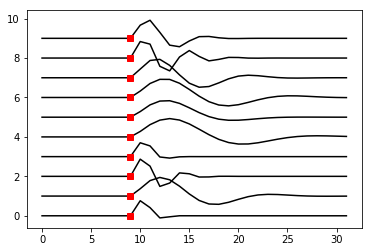

In [7]:
ns, nr = 32, 1024
batch_size = 32
epochs = 128
learning_rate = 1e-1
nu = ns
x, y = s.generate_data_set(nr, ns, n_min=.0, n_max=0, f_min=.1, f_max=.5, g_min=1, g_max=10, t0_min=.3, t0_max=.3)
x_test, y_test = s.generate_data_set(128, ns, n_min=.1, n_max=.1, f_min=.3, f_max=.5, g_min=5, g_max=10)
s.plot_sdata_jy(x, true=y)

In [20]:
x

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.89255252e-37,  1.02760242e-41, -6.12649510e-45],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.03986068e-03, -6.23495834e-03, -3.51446454e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.53202861e-11, -8.77777462e-12,  5.97733839e-13],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.87042071e-04,  1.23306686e-04,  9.00320932e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.28053419e-16, -1.61132422e-18,  2.96746402e-20],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.13698024e-17,  9.82530817e-20,  1.45164632e-20]])

## ANN
Рассмотрим использование простой полносвязной сети, без каких-либо дополнительных слоев типа пулинга или дропаута 

In [9]:
model = Sequential()
model.add(Dense(nu, activation='relu', input_dim=ns))
model.add(Dense(ns, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(lr=learning_rate),
              metrics=['accuracy'])

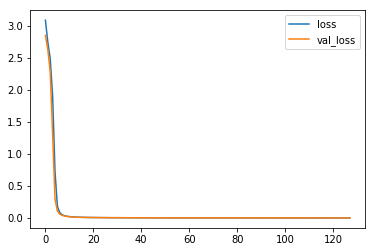

In [10]:
model.fit(x, y,
          epochs=epochs,
          batch_size=32,
          callbacks=[plot_losses],
          validation_split=.1)

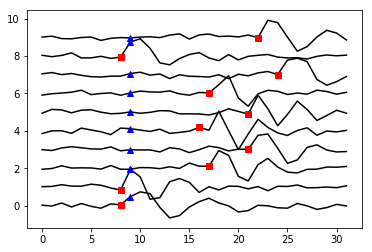

In [12]:
yp = model.predict_classes(x_test)
s.plot_sdata_jy(x_test, true=y_test, pred=yp)

## CNN
Рассмотрим пример добавления одного сверточного слоя

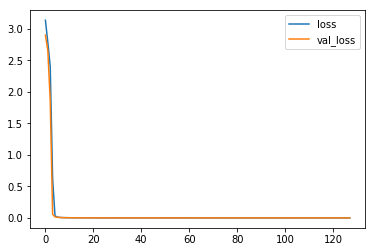

In [13]:
# для сверточной сети, даже 1D, необходимо чтобы входной массив был 3D
xe = np.expand_dims(x, axis=-1)

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=32,
                     padding='valid', 
                     activation='relu', 
                     input_shape=(ns, 1)))

# необходимо привести результаты применения свертки к 2D виду
model.add(Flatten())    
model.add(Dense(nu, activation='relu'))
model.add(Dense(ns, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(lr=learning_rate),
              metrics=['accuracy'])
model.fit(xe, y,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[plot_losses],
          validation_split=.1)

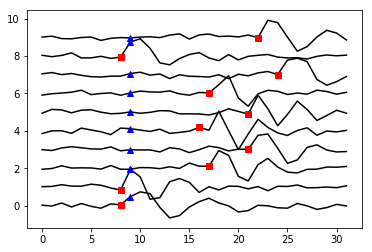

In [14]:
yp = model.predict_classes(np.expand_dims(x_test, axis=-1))
s.plot_sdata_jy(x_test, true=y_test, pred=yp)

## LSTM
рассмотрим рекурентную сеть

In [15]:
def create_sequence(x, timesteps, overlap):
    nr, ns = x.shape
    z = []
    for _x in x:
        t = []
        for s in np.arange(0, ns-timesteps, overlap):
            t.append(_x[s + np.arange(timesteps)])
        z.append(np.array(t).T)
    z = np.array(z)
    return z

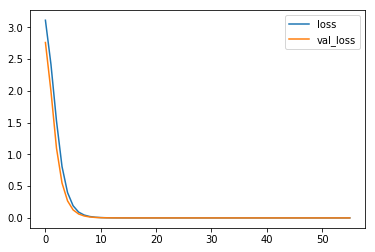

Epoch 57/128
768/921 [========================>.....] - ETA: 0s - loss: 3.5763e-06 - acc: 0.0000e+00

KeyboardInterrupt: 

In [16]:
timesteps = 16
overlap = 4
xl = create_sequence(x, timesteps, overlap)

model = Sequential()
model.add(LSTM(32, return_sequences=False, 
               activation='sigmoid',
               input_shape=xl.shape[1:3]))

# необходимо привести результаты применения свертки к 2D виду
# model.add(LSTM(32))
model.add(Dense(ns, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.fit(xl, y,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[plot_losses],
          validation_split=.1)

In [19]:
yp = model.predict_classes(np.expand_dims(x_test, axis=-1))
s.plot_sdata_jy(x_test, true=y_test, pred=yp)

ValueError: Error when checking : expected lstm_1_input to have shape (16, 4) but got array with shape (32, 1)

In [17]:
def load_pickle(path):
    with open(path, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin'
        data = u.load()
    return data

In [18]:
import pickle
data = load_pickle('3366samples.pickle')

FileNotFoundError: [Errno 2] No such file or directory: '3366samples.pickle'